<a href="https://colab.research.google.com/github/sm-ak-r33/Bias-Detection-SDXL-DPO-Text2Image-Model/blob/main/pathopulse_image_loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time

import json

import multiprocessing as mp

from urllib.request import urlopen, Request

from typing import Dict, Any

import math

import numpy as np

import imageio as iio

import cv2

import urllib.parse


In [ ]:
import json
from typing import Dict, Any
from urllib.request import Request, urlopen

def _load_ndpi_properties(image_id: str) -> Dict[str, Any]:
    # Base URL
    url_root = "http://pathogate.net/umbraco/api/IMSPublic/getImageInfo?imageId="
    url = url_root + image_id
    req = Request(url, headers={"User-Agent": "Magic Browser"})

    with urlopen(req) as f:
        s = f.read().decode("UTF8").replace("\\", "")
        info_new = json.loads(s[1:-1])

    print(info_new)
    return info_new


image_id = "135644b8-b608-4a16-bcc9-1b7ba38db320"
info = _load_ndpi_properties(image_id)


{'PixelWidth': '115536', 'PixelHeight': '64929', 'PhysicalWidth': '', 'PhysicalHeight': '', 'Mppx': '0.25190000000000001', 'Mppy': '0.25190000000000001', 'PixelsPrMeter': '3969829.29734021', 'ZStackMin': '', 'ZStackMax': '', 'ZStackLayers': '', 'TileLayersMin': '0', 'TileLayersMax': '17', 'TileLayersNumber': '18', 'Tiles': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 1], [4, 2], [8, 4], [15, 8], [29, 16], [57, 32], [114, 64], [228, 128], [455, 256]], 'Lens': '40', 'Rotation': 180, 'Flipped': False, 'BoundaryX': '10471.0689716691', 'BoundaryY': '2328.29628614361', 'BoundaryW': '22905.9994476175', 'BoundaryH': '61564.1712297907', 'ImageType': 'openslide', 'Path': 'https://openslide.pathogate.net//openslideimages/cba38b5b-1686-48ff-9f87-1e30aa720d72/135644b8-b608-4a16-bcc9-1b7ba38db320/Case08_HE.svs.dzi', 'LocalPath': '/openslideimages/cba38b5b-1686-48ff-9f87-1e30aa720d72/135644b8-b608-4a16-bcc9-1b7ba38db320/Case08_HE.svs', 'FolderId': '60000000-0000-0000-0

In [ ]:
image_id = "8070518b-4fdf-4a05-8e8f-69442569aecb"
info = _load_ndpi_properties(image_id)


{'PixelWidth': '21912', 'PixelHeight': '59405', 'PhysicalWidth': '', 'PhysicalHeight': '', 'Mppx': '0.25190000000000001', 'Mppy': '0.25190000000000001', 'PixelsPrMeter': '3969829.29734021', 'ZStackMin': '', 'ZStackMax': '', 'ZStackLayers': '', 'TileLayersMin': '0', 'TileLayersMax': '16', 'TileLayersNumber': '17', 'Tiles': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [2, 4], [3, 8], [6, 15], [11, 30], [22, 59], [44, 117], [87, 234]], 'Lens': '40', 'Rotation': 0, 'Flipped': False, 'BoundaryX': None, 'BoundaryY': None, 'BoundaryW': None, 'BoundaryH': None, 'ImageType': 'openslide', 'Path': 'https://openslide.pathogate.net//openslideimages/cba38b5b-1686-48ff-9f87-1e30aa720d72/8070518b-4fdf-4a05-8e8f-69442569aecb/Case08_HER2.svs.dzi', 'LocalPath': '/openslideimages/cba38b5b-1686-48ff-9f87-1e30aa720d72/8070518b-4fdf-4a05-8e8f-69442569aecb/Case08_HER2.svs', 'FolderId': '60000000-0000-0000-0000-000000000000'}


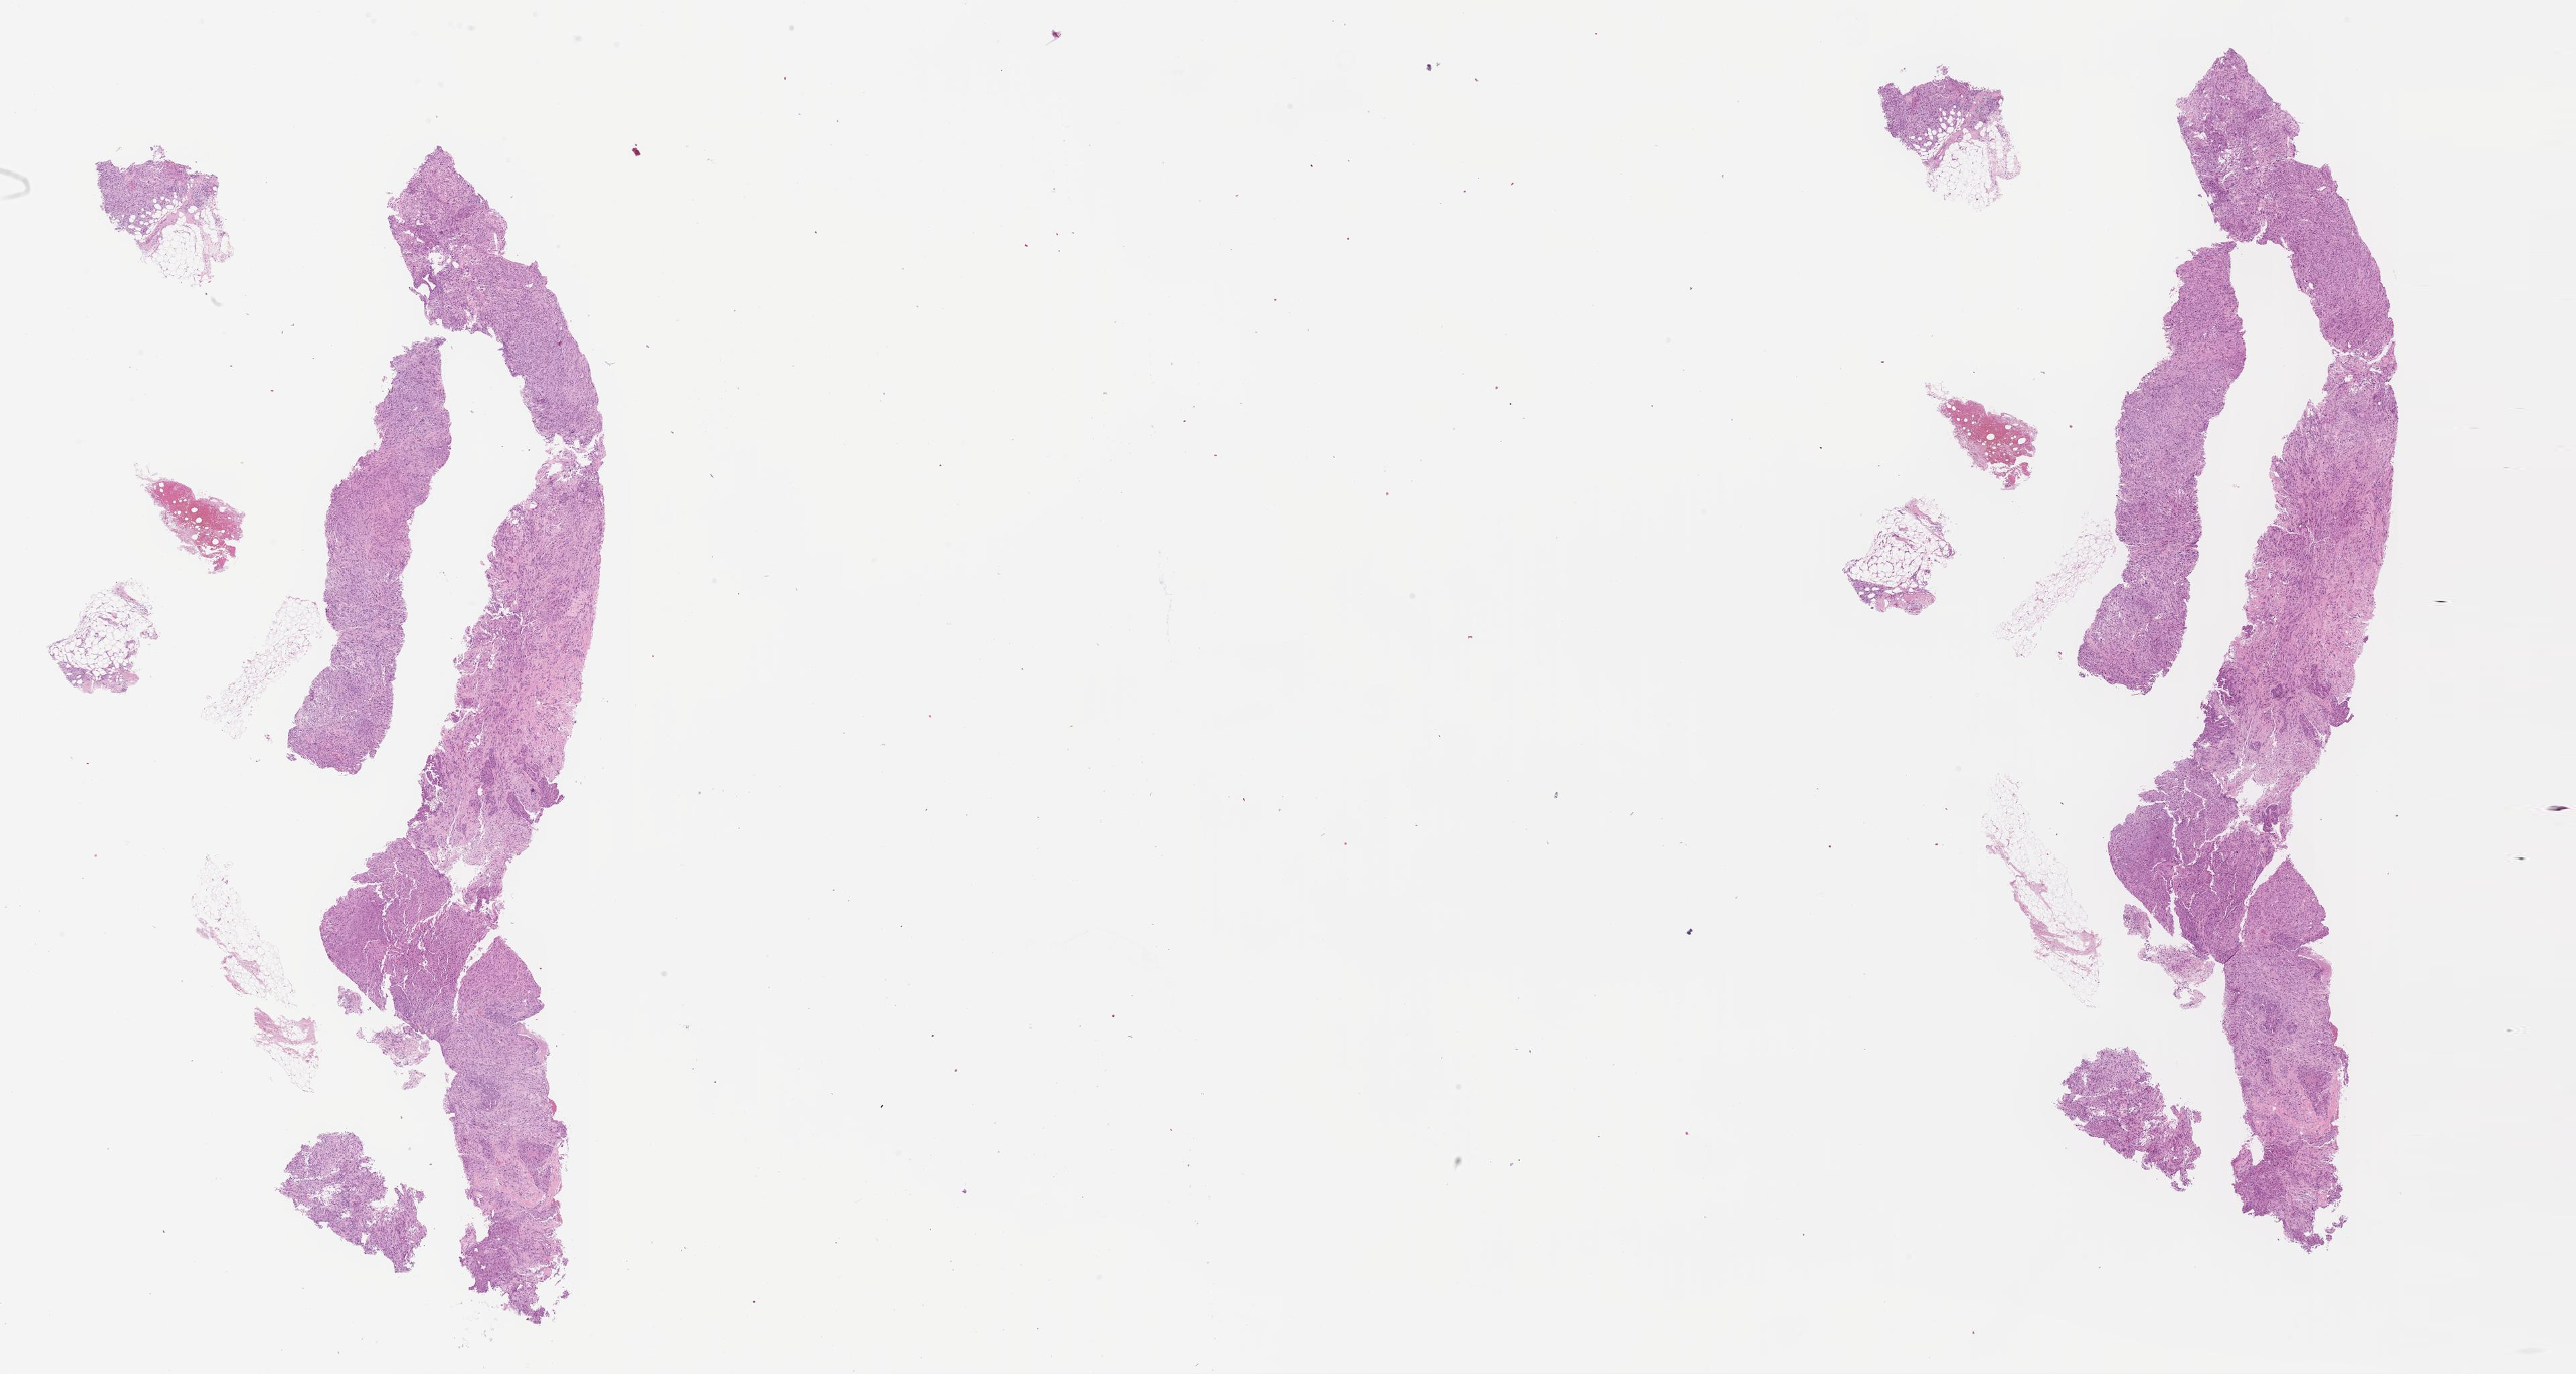

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np

def fetch_tile(url: str) -> Image.Image:
    """Fetch a tile image from the URL and return it as a PIL Image."""
    try:
        response = requests.get(url)
        response.raise_for_status()
        return Image.open(BytesIO(response.content))
    except Exception as e:
        print(f"Error fetching tile from {url}: {e}")
        return None

def stitch_tiles(tile_urls: list, grid_size: tuple, tile_size: tuple) -> Image.Image:
    """Stitch tiles into a single image."""
    num_rows, num_cols = grid_size
    tile_width, tile_height = tile_size

    # Create a blank canvas for the final stitched image
    stitched_image = Image.new('RGB', ( num_rows * tile_height, num_cols * tile_width))

    for idx, url in enumerate(tile_urls):
        row = idx // num_cols
        col = idx % num_cols

        img = fetch_tile(url)
        if img:
            img = img.resize((tile_width, tile_height))  # Ensure tile is the correct size
            stitched_image.paste(img, ( row *tile_height, col *  tile_width))

    return stitched_image

def generate_tile_urls(base_url: str, zoom_level: int, num_tiles_x: int, num_tiles_y: int) -> list:
    """Generate tile URLs for a given zoom level and grid dimensions."""
    return [f"{base_url}/{zoom_level}/{row}_{col}.jpeg" for row in range(num_tiles_x) for col in range(num_tiles_y)]

# Example parameters
tile_base_url = "https://openslide.pathogate.net/openslideimages/cba38b5b-1686-48ff-9f87-1e30aa720d72/135644b8-b608-4a16-bcc9-1b7ba38db320/Case08_HE.svs_files"
zoom_level = 12
num_tiles_x = 15
num_tiles_y = 8
tile_size = (256, 256)  # Specify the size of each tile

# Generate tile URLs
tile_urls = generate_tile_urls(tile_base_url, zoom_level, num_tiles_x, num_tiles_y)

# Stitch tiles into one image
stitched_image = stitch_tiles(tile_urls, (num_tiles_x,num_tiles_y), tile_size)

# Display the final image
stitched_image


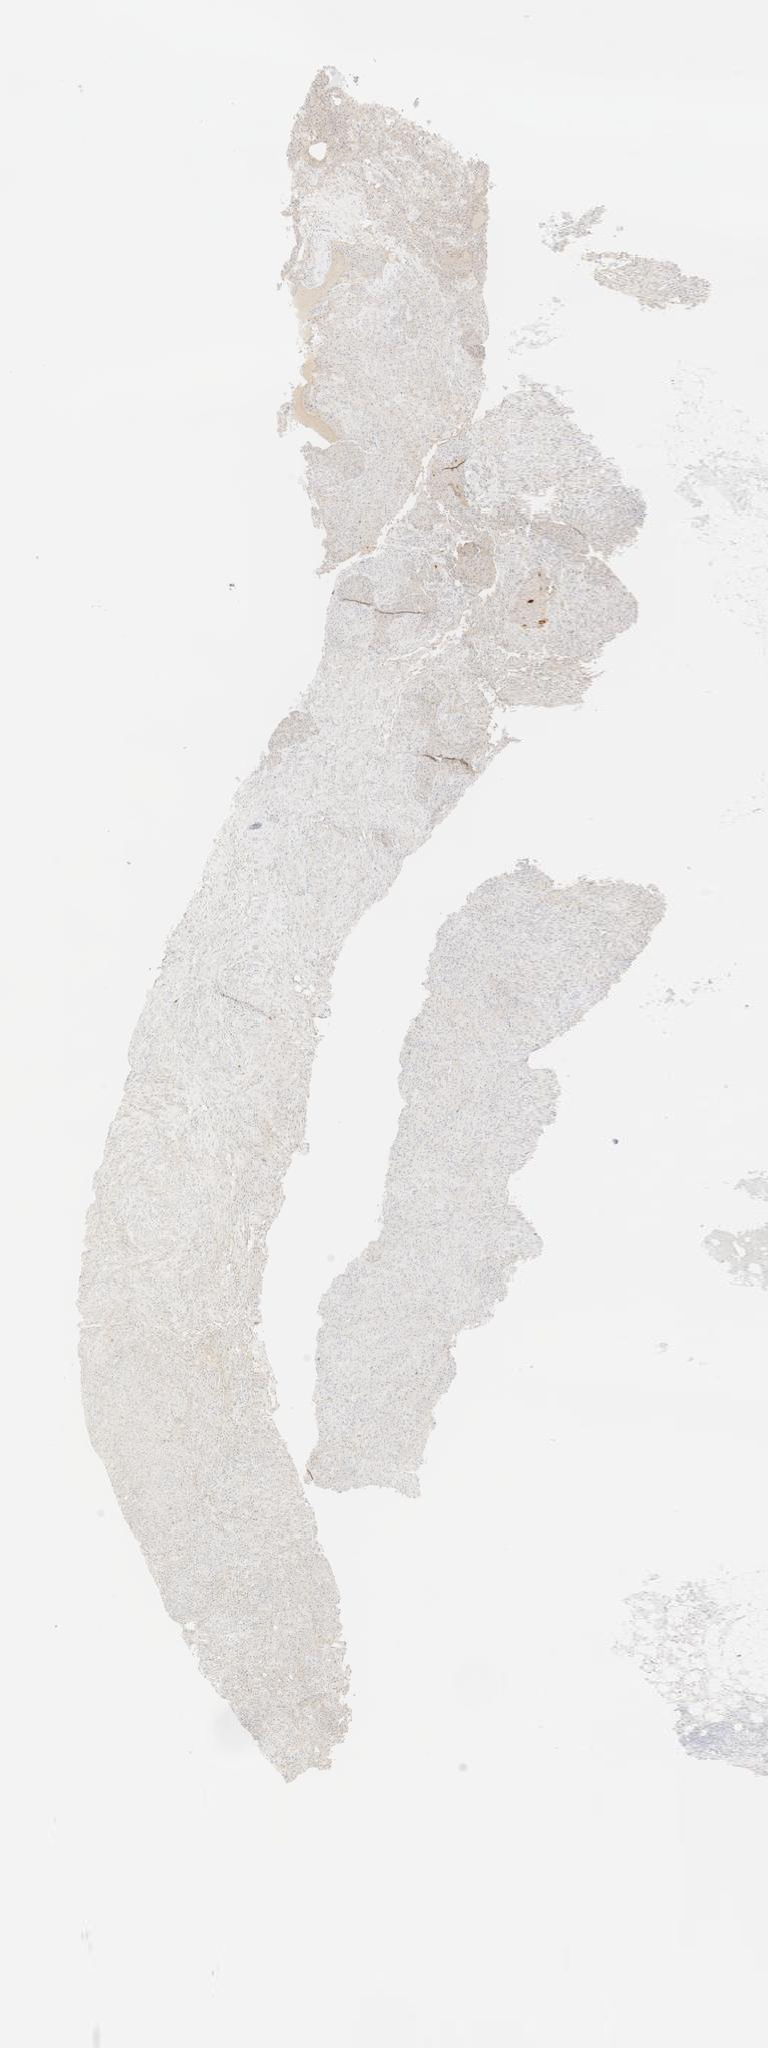

In [ ]:
tile_base_url = "https://openslide.pathogate.net/openslideimages/cba38b5b-1686-48ff-9f87-1e30aa720d72/8070518b-4fdf-4a05-8e8f-69442569aecb/Case08_HER2.svs_files/"
zoom_level = 11
num_tiles_x = 3
num_tiles_y = 8
tile_size = (256, 256)  # Specify the size of each tile


# Generate tile URLs
tile_urls = generate_tile_urls(tile_base_url, zoom_level, num_tiles_x, num_tiles_y)

# Stitch tiles into one image
stitched_image = stitch_tiles(tile_urls, (num_tiles_x,num_tiles_y), tile_size)

# Display the final image
stitched_image
